# Candidate analysis

- Which candidate set has the best precision / recall trade-off?
- 

In [666]:
%matplotlib inline
import pandas as pd
import glob, os
pd.set_option('display.max_colwidth', -1)

import urllib.parse, string
SAFE = ''.join(sorted(set(string.printable) - set('?"\\`%^')))
quote = lambda uri: urllib.parse.quote(uri, SAFE)
unquote = lambda uri: urllib.parse.unquote(uri)
def clean_uri(uri):
    return unquote(unquote(redir.get(uri,uri).replace('http://dbpedia.org/resource/','')))

# gold_path = './t2k/data/v1/'
gold_path = './sti/data/webarooListsAsWikiTables/'

gs_instance_fname = os.path.join(gold_path,'gs_instance.csv')
gs_instance = pd.read_csv(gs_instance_fname, header=None, names=['row', 'uri', 'gold'])
gs_instance['uri'] = gs_instance['uri'].map(clean_uri)
print(f'Loaded {len(gs_instance)} gold instances')

# run = '3dec-candidates' # only labels
# run = '15feb-v1-linklabelindex' # labels and outlinks, very good
# run = '19feb-v1-linklabelindex-spanfuzz' # disappointing
# run = '23feb-v1-dbpedia2014' # worse than 15feb
# run = '1mar-v1-dbpedia2014-onlylabels' # pretty OK

# run = '14mar-t2dv1-dbpedia2014-tokenjacc_cutoff'
# run = '14mar-t2dv1-dbpedia2014anchors-tokenjacc_cutoff'

# run = '18mar-t2dv1-dbpedia2014_intl/'
# run = '18mar-t2dv1-dbpedia2014-tokenjacc_cutoff'

run = '24mar-webaroo-dbpedia2014'


fnames = glob.glob(f'results/{run}/candidates/*.csv')

df = pd.concat([pd.read_csv(fname) for fname in fnames])
df['uri'] = df['entity'].map(clean_uri)
# Filter candidate sets that are too large
# df = df[df.groupby('row')['uri'].transform('count') < 100]
df = df[df.groupby(['row','uri'])['score'].transform('max') == df['score']].drop_duplicates()
df = df[df['uri'].map(lambda uri: not uri.startswith('Category:'))]
our_candidates = df[['row', 'uri', 'score']]
print(f'Loaded {len(our_candidates)} of our candidates')

rowcontent = df[['row', 'rowcontent']].sort_values('row').drop_duplicates().set_index('row')
print(f'Loaded {len(rowcontent)} row contents')

# t2k_dir = 'output-v1'
t2k_dir = 'webarooListsAsWikiTables-output'

t2k_fnames = glob.glob(f't2k/data/{t2k_dir}/instance_candidates/candidate/*.csv')
df = pd.concat([pd.read_csv(fname) for fname in t2k_fnames])
df['uri'] = df['entity'].map(clean_uri)
df = df[df.groupby(['row','uri'])['score'].transform('max') == df['score']].drop_duplicates()
t2k_candidates = df[['row','uri', 'score']]
print(f'Loaded {len(t2k_candidates)} of t2k candidates')

# rowcontent = df[['row', 'rowcontent']].sort_values('row').drop_duplicates().set_index('row')
# print(f'Loaded {len(rowcontent)} row contents')

Loaded 4447 gold instances
Loaded 56627 of our candidates
Loaded 9779 row contents
Loaded 44513 of t2k candidates


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd94746ea20>,
      dtype=object)

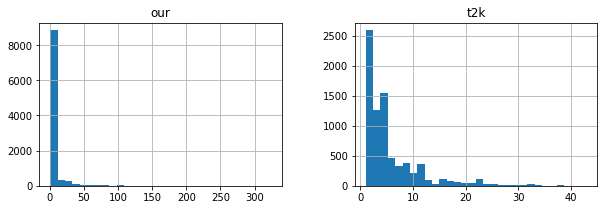

In [667]:
# What is the distribution of candidate set sizes?
agg = pd.DataFrame({
    'our': our_candidates.groupby('row')['uri'].agg('count'),
    't2k': t2k_candidates.groupby('row')['uri'].agg('count')
})
agg.hist(bins=30, figsize=(10,3))

In [668]:
# What are the scores?
merged = our_candidates.merge(t2k_candidates, how='outer', on=['row','uri'], suffixes=('_our', '_t2k'))
merged['uri'] = merged['uri'].map(clean_uri)
merged = merged.fillna(0)
merged = merged.merge(gs_instance, on=['row','uri'], how='outer')
merged['gold'] = merged['gold'].fillna(False)
merged = merged.fillna(0)

merged['score_our_best'] = merged['score_our']
merged.loc[(merged.groupby('row')['score_our'].transform('max') != merged['score_our']), 'score_our_best'] = 0
merged['score_t2k_best'] = merged['score_t2k']
merged.loc[(merged.groupby('row')['score_t2k'].transform('max') != merged['score_t2k']), 'score_t2k_best'] = 0

merged = merged.merge(rowcontent.reset_index(), on='row', how='outer')

merged = merged.sort_values(['row', 'score_our', 'gold'], ascending=False)
merged = merged.drop_duplicates()
merged['rank_our'] = merged.groupby('row').cumcount()
print(f'Created {len(merged)} merged candidates\n')


def scores(df, col):
    n_correct = sum((df[col]>0) & df['gold'])
    n_retrieved = sum(df[col]>0)
    n_relevant = sum(df['gold'])
    p = n_correct / n_retrieved
    r = n_correct / n_relevant
    return p,r,n_retrieved


print('t2k: p=%.2f r=%.2f (%d total)' % scores(merged, 'score_t2k'))
print('t2k best: p=%.2f r=%.2f (%d total)' % scores(merged, 'score_t2k_best'))

print()
print(run)
print('our: p=%.2f r=%.2f (%d total)' % scores(merged, 'score_our'))
print('our best: p=%.2f r=%.2f (%d total)' % scores(merged, 'score_our_best'))

Created 91101 merged candidates

t2k: p=0.04 r=0.40 (44513 total)
t2k best: p=0.12 r=0.38 (14739 total)

24mar-webaroo-dbpedia2014
our: p=0.07 r=0.91 (56627 total)
our best: p=0.08 r=0.90 (53430 total)


In [669]:
# For how many rows are we missing candidates?
agg['gold'] = gs_instance.groupby('row')['uri'].agg('count')
agg = agg.fillna(0)
our_missing = agg[ (agg['gold'] >0) & (agg['our'] ==0) ]
print(f'We are missing candidates for {len(our_missing)} rows')

t2k_missing = agg[ (agg['gold'] >0) & (agg['t2k'] ==0) ]
print(f'T2K are missing candidates for {len(t2k_missing)} rows')

We are missing candidates for 51 rows
T2K are missing candidates for 361 rows


In [670]:
DB_PATH = './data/dbpedia/2014_part/'
# DB_PATH = './data/dbpedia/db_part/'
import trident, urllib
db = trident.Db(DB_PATH)
missing = set()
for uripart in merged[merged['gold']]['uri']:
    uripart = quote(uripart)
    s = db.lookup_id(f'<http://dbpedia.org/resource/{uripart}>')
    if not s:
        missing.add(unquote(uripart))
print('There are %d gold entities missing from the KB:' % len(missing))
print(sorted(missing))

There are 7 gold entities missing from the KB:
['?And_Now_Miguel', 'CLEAR ATTACHNENT', 'Homer_vs._Patty_\\amp_Selma', 'Itchy_\\amp_Scratchy_Land', 'Malaysia_University_of_Science_\\amp_Technology', 'Ontario_College_of_Art_\\amp_Design', 'Texas_A\\ampM_University']


In [671]:
# For how many rows are we missing the gold candidate?
print('We are missing the gold candidate %d times' % sum(merged['gold'] & (merged['score_our']==0)) )
print('T2K are missing the gold candidate %d times' % sum(merged['gold'] & (merged['score_t2k']==0)) )

# Which rows do we miss?
our_missing_rows = merged[merged['gold'] & (merged['score_our']==0)]['row']
our_missing = merged.set_index('row').loc[our_missing_rows]
our_missing = our_missing[['uri','gold','score_our','score_t2k','rowcontent','rank_our']]
our_missing = our_missing[our_missing['gold'] | (our_missing['rank_our'] == 0)]
our_missing.head(1000)

We are missing the gold candidate 408 times
T2K are missing the gold candidate 2671 times


,uri,gold,score_our,score_t2k,rowcontent,rank_our
row,,,,,,
file99290_1_cols1_rows63.csv~Row57,Roberts_(given_name),False,0.5000,0.00000,Robert McClosky|Make Way for Ducklings,0
file99290_1_cols1_rows63.csv~Row57,Robert_McCloskey,True,0.0000,0.00000,Robert McClosky|Make Way for Ducklings,115
file99290_1_cols1_rows63.csv~Row50,Berta_and_Elmer_Hader,False,1.0000,0.00000,Berta and Elmer Hader|The Big Snow,0
file99290_1_cols1_rows63.csv~Row50,Bill_Hader,True,0.0000,0.00000,Berta and Elmer Hader|The Big Snow,1
file99290_1_cols1_rows63.csv~Row47,Jean_Nicolas,False,0.5000,0.00000,Nicolas Mordvinoff|Finders Keepers,0
file99290_1_cols1_rows63.csv~Row47,Nicholas_Mordvinoff,True,0.0000,0.00000,Nicolas Mordvinoff|Finders Keepers,15
file99290_1_cols1_rows63.csv~Row-1,Simms_Taback,True,0.0000,0.00000,NaN,0
file99290_0_cols1_rows79.csv~Row66,Elizabeth_Lewis,False,1.0000,0.00000,Elizabeth Lewis|Young Fu of the Upper Yangtze,0
file99290_0_cols1_rows79.csv~Row66,Elizabeth_Foreman_Lewis,True,0.0000,0.00000,Elizabeth Lewis|Young Fu of the Upper Yangtze,1


There are 16544 gold entities at rank 0
There are 6713 gold entities further down than 0
There are 4256 gold entities further down than 1
There are 2969 gold entities further down than 2
There are 2239 gold entities further down than 3
There are 1664 gold entities further down than 4
There are 1319 gold entities further down than 5
There are 1124 gold entities further down than 6
There are 922 gold entities further down than 7
There are 781 gold entities further down than 8
There are 664 gold entities further down than 9


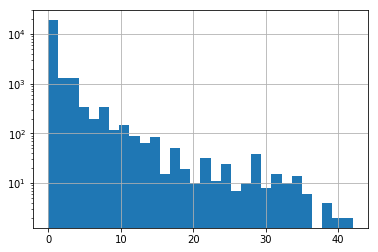

In [478]:
# What is the distribution of ranks for non-singleton candidate sets?
our_topranks = merged[merged['gold'] & (merged['score_our']>0)]['rank_our']


print(f'There are {sum(our_topranks==0)} gold entities at rank 0')
for i in range(10):
    print(f'There are {sum(our_topranks>i)} gold entities further down than {i}')
ax = our_topranks.hist(bins=30)
ax.set_yscale('log')


# pd.set_option('display.max_rows', 1000)

# our_merged = our_merged.merge(rowcontent.reset_index(), on='row')
# our_merged[our_merged['gold'] & (our_merged['rank'] != 0)]

In [479]:
# Which rows do we rank bad at?
our_bad_rank_rows = merged[merged['gold'] & (merged['score_our']>0) & (merged['rank_our']>10)]['row']
our_bad_rank = merged.set_index('row').loc[our_bad_rank_rows]
our_bad_rank = our_bad_rank[['uri','score_our','gold','rowcontent','rank_our']]
our_bad_rank = our_bad_rank[our_bad_rank['gold'] | (our_bad_rank['rank_our'] == 0)]
our_bad_rank.head(100)

,uri,score_our,gold,rowcontent,rank_our
row,,,,,
99070098_0_2074872741302696997.csv~Row12,"Fairfield,_Bedford_County,_Tennessee",30.7579,False,fairfield // e fells,0
99070098_0_2074872741302696997.csv~Row12,Fairfield_(Lake_District),30.4039,True,fairfield // e fells,27
98929678_0_3700213490979945526.csv~Row76,"Deer_Creek,_Taylor_County,_Wisconsin",25.1011,False,deer creek reservoir // utah united states,0
98929678_0_3700213490979945526.csv~Row76,Deer_Creek_Dam_and_Reservoir,24.5291,True,deer creek reservoir // utah united states,18
98929678_0_3700213490979945526.csv~Row69,Long_Lake_(Athabasca_County),32.1791,False,long lake // maine united states,0
98929678_0_3700213490979945526.csv~Row69,Long_Lake_(Maine),32.0059,True,long lake // maine united states,14
98929678_0_3700213490979945526.csv~Row173,Green_Lake_(Cariboo),31.1850,False,green lake // green lake county wisconsin united states,0
98929678_0_3700213490979945526.csv~Row173,"Green_Lake_County,_Wisconsin",25.3999,True,green lake // green lake county wisconsin united states,32
98458255_0_5873264818593370400.csv~Row91,"The_National_Academy_of_Sciences,_India",37.1623,False,proceedings of the national academy of sciences of the usa // yes publisher or author yes national academy of sciences,0
